# Chapter 4 Exercises

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from matplotlib import gridspec

import warnings
warnings.simplefilter('ignore')

plt.style.use('ggplot')

colors= [c['color'] for c in plt.rcParams['axes.prop_cycle']]

# Applied

## Question 10

In [2]:
weekly = pd.read_csv('../data/weekly.csv')
weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


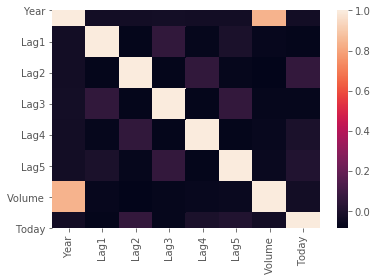

In [3]:
# 10.1 
sns.heatmap(weekly[weekly.columns[:-1]].corr())

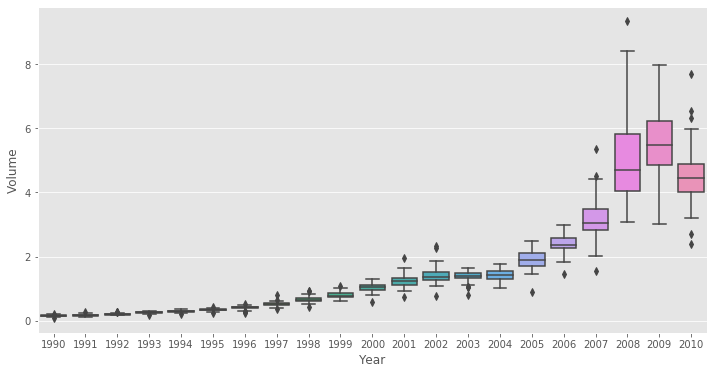

In [4]:
plt.figure(figsize=(12,6))
sns.boxplot(data=weekly, x='Year', y='Volume')

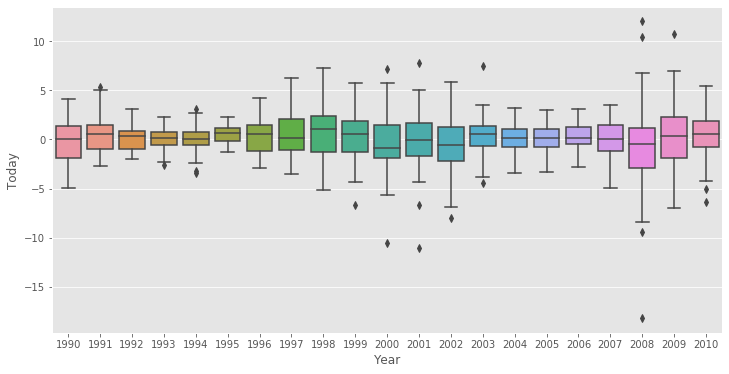

In [5]:
plt.figure(figsize=(12,6))
sns.boxplot(data=weekly, x='Year', y='Today')

### 10.2

In [6]:
X = weekly[['Lag1','Lag2','Lag3','Lag4','Lag5','Volume']]
y, classes = weekly.Direction.factorize()

sm_model = sm.Logit(y, sm.add_constant(X)).fit(disp=0)
sm_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.007    
Dependent Variable: y                AIC:              1500.3571
Date:               2020-04-20 14:37 BIC:              1535.3082
No. Observations:   1089             Log-Likelihood:   -743.18  
Df Model:           6                LL-Null:          -748.10  
Df Residuals:       1082             LLR p-value:      0.13132  
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     4.0000                                      
------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025   0.975]
------------------------------------------------------------------
const      0.2669     0.0859    3.1056   0.0019    0.0984   0.4353
Lag1      -0.0413     0.0264   -1.5626   0.1181   -0.0930   0.0105
Lag2       0.0584     0.0269    2.1754   0.0296    0.0058   0.1111
Lag3      -0.0161     0.0267   -0.6024   0.5469   -0.0683   0.0362
Lag4      -0.0278     0.0265   -1.0501   0.2937   -0.0797   0.0241
Lag5      -0.0145     0.0264   -0.5485   0.5833   -0.0662   0.0372
Volume    -0.0227     0.0369   -0.6163   0.5377   -0.0951   0.0496
================================================================

"""

Only the constant intercept and `Lag2` seems to be significant at all. 

### 10.3

Overall Accuracy:  0.5610651974288338


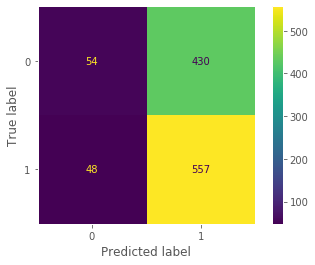

In [7]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression

sk_model = LogisticRegression()
sk_model.fit(X, y)

preds = sk_model.predict(X)

print('Overall Accuracy: ',accuracy_score(y, preds))

plot_confusion_matrix(sk_model, X, y, values_format='.0f')
plt.grid(None)

We are predicting many False negatives

### 10.4

LogisticRegression
Train Accuracy:  0.5553299492385787
Val Accuracy:  0.625


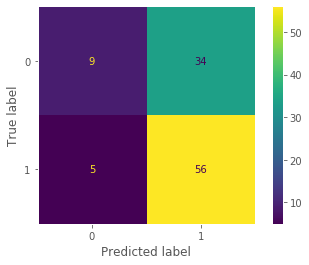

LDA
Train Accuracy:  0.5543147208121827
Val Accuracy:  0.625


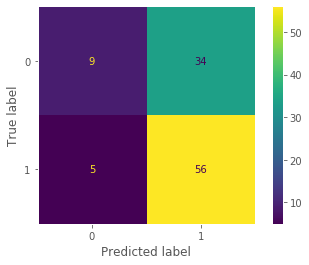

QDA
Train Accuracy:  0.5522842639593909
Val Accuracy:  0.5865384615384616


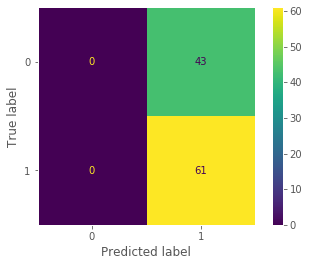

KNN
Train Accuracy:  0.9573604060913705
Val Accuracy:  0.5


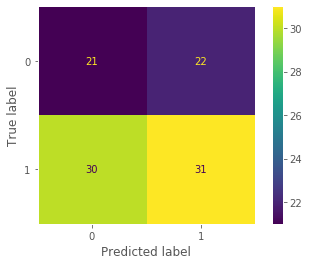

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

d_train = weekly.query('1990<=Year<=2008')
d_val = weekly.query('Year>2008')

X = d_train[['Lag2']]
y,_ = d_train.Direction.factorize()

X_val = d_val[['Lag2']]
y_val, _ = d_val.Direction.factorize()


models = [
    ('LogisticRegression',LogisticRegression()), 
    ('LDA',LinearDiscriminantAnalysis()), 
    ('QDA',QuadraticDiscriminantAnalysis()),
    ('KNN',KNeighborsClassifier(n_neighbors=1))
]


scores = {}
for name, model in models:
    print(name)
    model.fit(X, y)
    
    tr_preds = model.predict(X)
    val_preds = model.predict(X_val)
    
    tr_acc = accuracy_score(y, tr_preds)
    val_acc = accuracy_score(y_val, val_preds)
    
    print('Train Accuracy: ',tr_acc)
    print('Val Accuracy: ',val_acc)
    
    plot_confusion_matrix(model, X_val, y_val, values_format='.0f')
    
    scores[name] = {
        'train': tr_acc,
        'val': val_acc
    }
    
    plt.grid(None)
    plt.show()

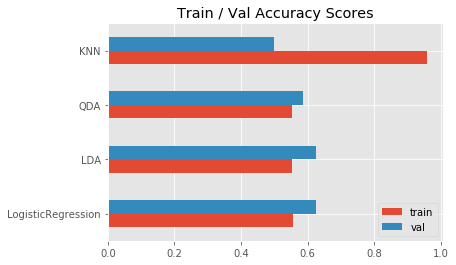

In [9]:
pd.DataFrame.from_dict(scores, orient='index').plot.barh(title='Train / Val Accuracy Scores');

* KNN clearly overfitting.
* LDA & LogisticRegreesion seem to have similar and best val score

Text(0.5, 1.0, 'Accuracy over K Neighbours')

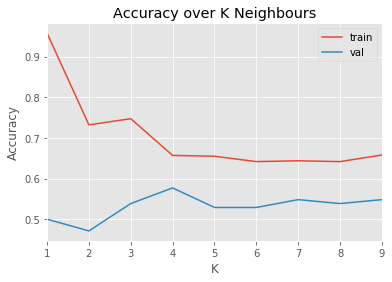

In [10]:
# Test scores with higher values of K
scores = {}
for k in range(1, 10):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X, y)
    tr_preds = model.predict(X)
    val_preds = model.predict(X_val)
    
    tr_acc = accuracy_score(y, tr_preds)
    val_acc = accuracy_score(y_val, val_preds)
    
    scores[k] = {
        'train': tr_acc,
        'val': val_acc
    }

scores_df = pd.DataFrame.from_dict(scores, orient='index')
scores_df.plot()
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy over K Neighbours')

### Feature engineering

**% Change per day**

`Today` is the percentage _return_ that day, with negative values indicating a loss and positive values indicating a gain. 

We can turn this value into percentage _change_ that day, which reflects the movement around 1:
* no return = 1
* a loss equals < 1
* a gain equals > 1

Or:

$$
T_P = 1 + \frac{Td}{100}
$$

Where:
* $T_P$: Percentage change today
* $T_R$: Return today


**Cumulative Product**

Because $T_P$ is a percentage (reflected around 1), if we take the _cumulative product_ we get the _growth_ (cumulative multiplications >1 will lead to growth). 

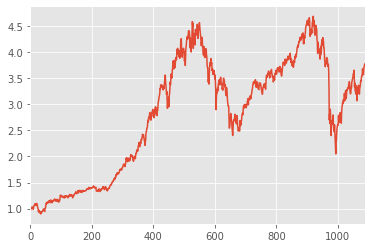

In [11]:
today = weekly['Today']

today_perc = (100 + today) / 100

# today_perc.head()
today_perc.cumprod().plot();

### Make lag percentages

In [17]:
for lag in range(1,6):
    col=f'Lag{lag}'
    weekly[col+"_perc"] = 1 + weekly[col]/100

In [18]:
weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,Lag1_perc,Lag2_perc,Lag3_perc,Lag4_perc,Lag5_perc
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down,1.00816,1.01572,0.96064,0.99771,0.96516
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down,0.99730,1.00816,1.01572,0.96064,0.99771
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up,0.97424,0.99730,1.00816,1.01572,0.96064
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up,1.03514,0.97424,0.99730,1.00816,1.01572
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up,1.00712,1.03514,0.97424,0.99730,1.00816


In [38]:
d_train = weekly.query('1990<=Year<=2008')
d_val = weekly.query('Year>2008')

train_cols = [
    'Lag2',
    'Lag2_perc'
]

X = d_train[train_cols]
y,_ = d_train.Direction.factorize()

X_val = d_val[train_cols]
y_val, _ = d_val.Direction.factorize()

In [39]:
models = [
    ('LogisticRegression',LogisticRegression()), 
    ('LDA',LinearDiscriminantAnalysis()), 
    ('QDA',QuadraticDiscriminantAnalysis()),
    ('KNN',KNeighborsClassifier(n_neighbors=4))
]


scores = {}
for name, model in models:
    print(name)
    model.fit(X, y)
    
    tr_preds = model.predict(X)
    val_preds = model.predict(X_val)
    
    tr_acc = accuracy_score(y, tr_preds)
    val_acc = accuracy_score(y_val, val_preds)
    
    print('Train Accuracy: ',tr_acc)
    print('Val Accuracy: ',val_acc)
    print('')

    
    scores[name] = {
        'train': tr_acc,
        'val': val_acc
    }

LogisticRegression
Train Accuracy:  0.5553299492385787
Val Accuracy:  0.625

LDA
Train Accuracy:  0.5543147208121827
Val Accuracy:  0.625

QDA
Train Accuracy:  0.5522842639593909
Val Accuracy:  0.5865384615384616

KNN
Train Accuracy:  0.6588832487309645
Val Accuracy:  0.5769230769230769



Text(0.5, 1.0, 'Accuracy over K Neighbours')

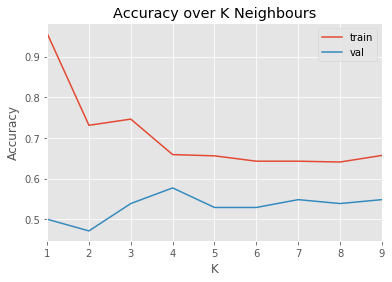

In [40]:
# Test scores with higher values of K
scores = {}
for k in range(1, 10):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X, y)
    tr_preds = model.predict(X)
    val_preds = model.predict(X_val)
    
    tr_acc = accuracy_score(y, tr_preds)
    val_acc = accuracy_score(y_val, val_preds)
    
    scores[k] = {
        'train': tr_acc,
        'val': val_acc
    }

scores_df = pd.DataFrame.from_dict(scores, orient='index')
scores_df.plot()
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy over K Neighbours')

In [42]:
scores_df.sort_values(by='val')

,train,val
2,0.730964,0.471154
1,0.957360,0.500000
5,0.655838,0.528846
6,0.642640,0.528846
3,0.746193,0.538462
8,0.640609,0.538462
7,0.642640,0.548077
9,0.656853,0.548077
4,0.658883,0.576923


## Question 11

In [43]:
auto = pd.read_csv('../data/auto.csv')
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


### 11.a

In [44]:
auto['mpg01'] = np.where(auto.mpg.values>auto.mpg.median(), 1, 0)

### 11.b

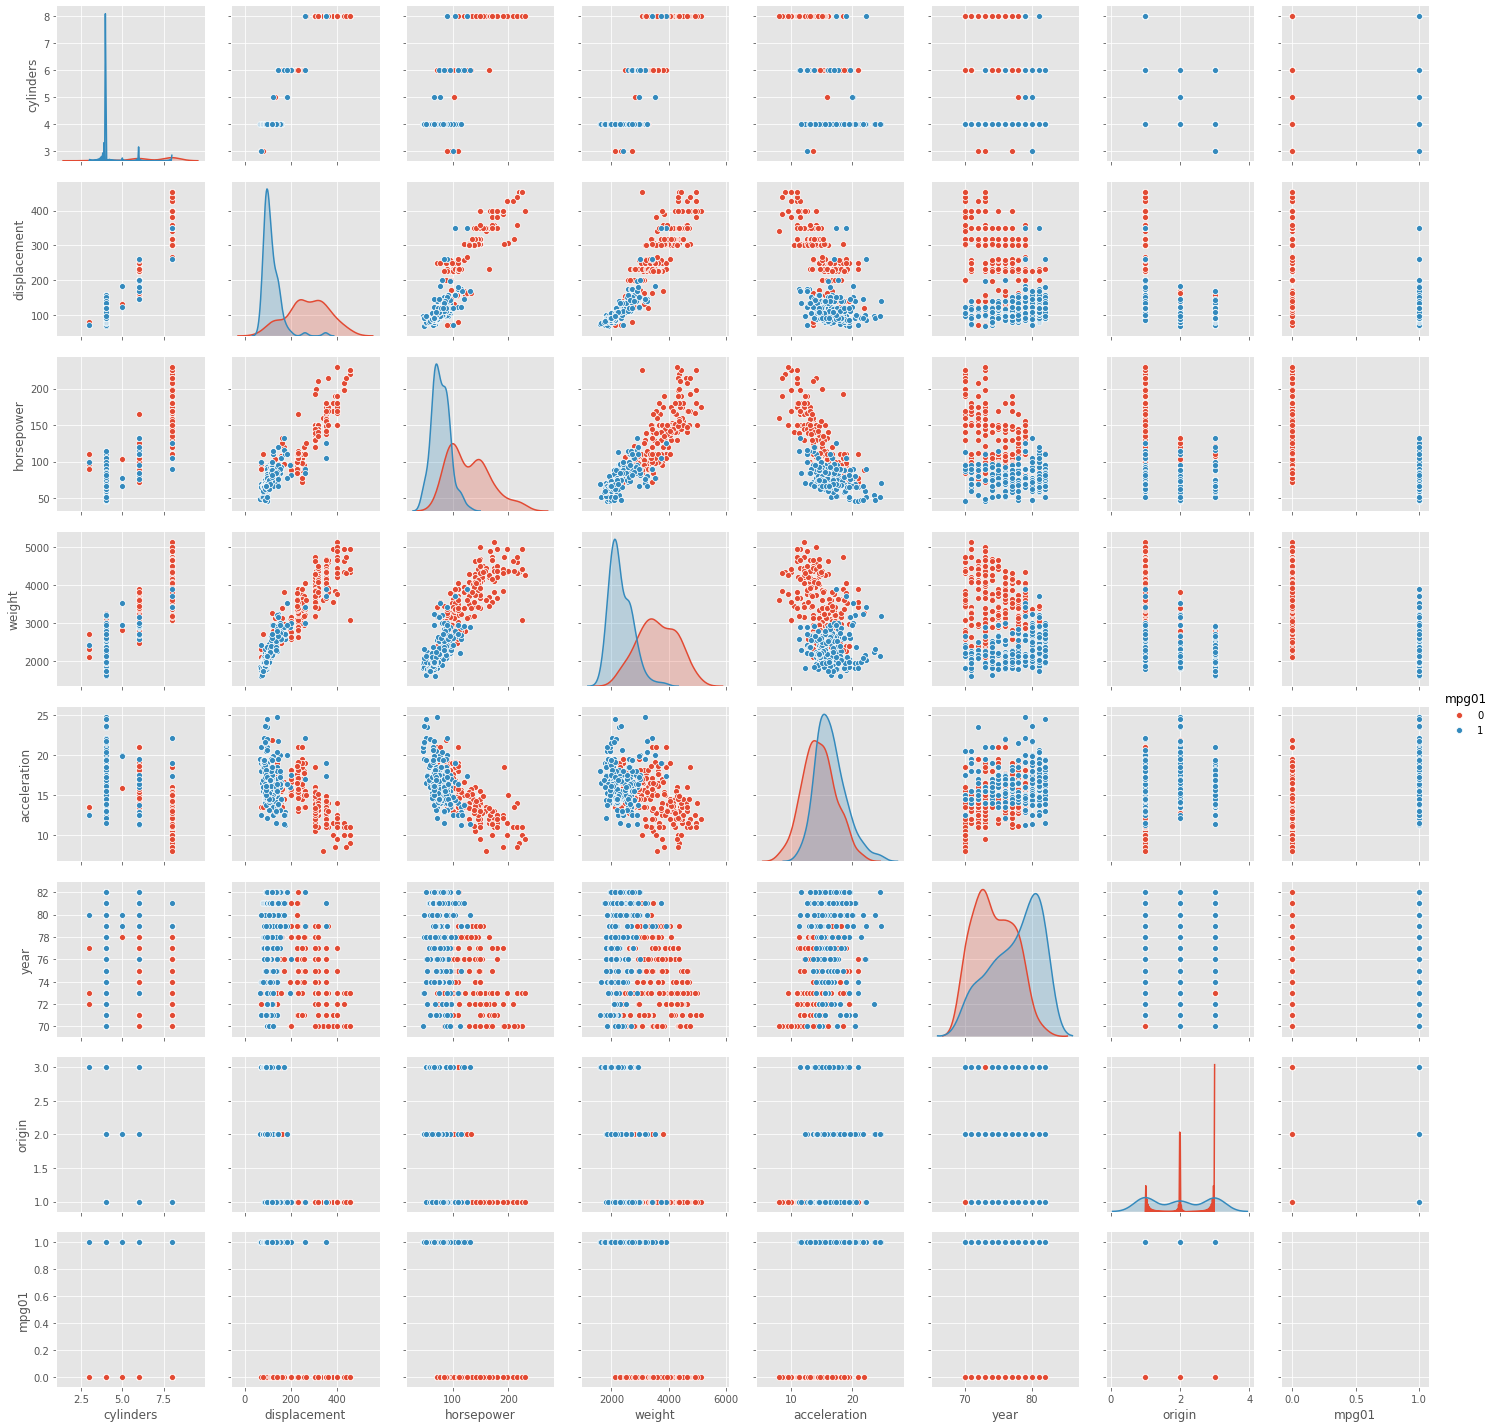

In [45]:
sns.pairplot(data=auto.drop(columns=['mpg','name']), hue='mpg01')

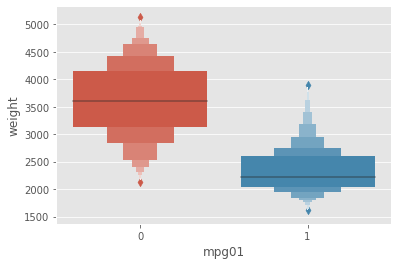

In [46]:
sns.boxenplot(data=auto, x='mpg01',y='weight')

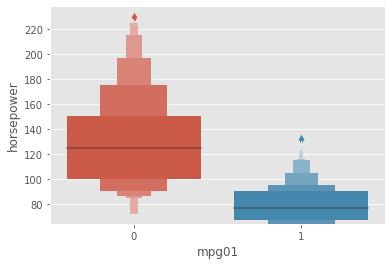

In [47]:
sns.boxenplot(data=auto, x='mpg01',y='horsepower')

In [48]:
from sklearn.model_selection import train_test_split

X = auto.drop(columns=['mpg','name'])
y = auto.mpg01

cols = ['cylinders', 'displacement', 'horsepower', 'weight','acceleration']
X = X[cols]

X_train, X_val, y_train, y_val = train_test_split(X, y)


models = [
    ('LR',LogisticRegression()), 
    ('LDA',LinearDiscriminantAnalysis()), 
    ('QDA',QuadraticDiscriminantAnalysis()),
    ('KNN (1)',KNeighborsClassifier(n_neighbors=1)),
    ('KNN (5)',KNeighborsClassifier(n_neighbors=5))
]

for name, model in models:
    
    print(name,end='\t')
    model.fit(X_train, y_train)
    val_preds = model.predict(X_val)
    print('Val acc: ',accuracy_score(y_val, val_preds))

LR	Val acc:  0.9183673469387755
LDA	Val acc:  0.8979591836734694
QDA	Val acc:  0.9081632653061225
KNN (1)	Val acc:  0.8979591836734694
KNN (5)	Val acc:  0.9081632653061225


Text(0.5, 1.0, 'Accuracy over K Neighbours')

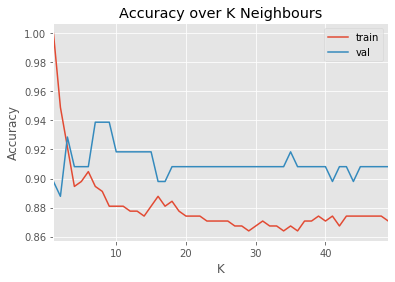

In [49]:
scores = {}
for k in range(1, 50):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    tr_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    
    tr_acc = accuracy_score(y_train, tr_preds)
    val_acc = accuracy_score(y_val, val_preds)
    
    scores[k] = {
        'train': tr_acc,
        'val': val_acc
    }

scores_df = pd.DataFrame.from_dict(scores, orient='index')
scores_df.plot()
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy over K Neighbours')

Train Accuracy:  0.9217687074829932
Val Accuracy:  0.9285714285714286


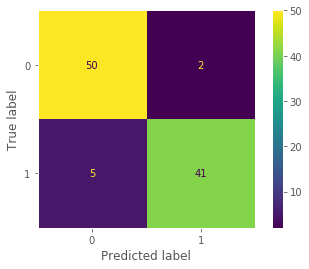

In [50]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)
tr_preds = model.predict(X_train)
val_preds = model.predict(X_val)

tr_acc = accuracy_score(y_train, tr_preds)
val_acc = accuracy_score(y_val, val_preds)

print('Train Accuracy: ',tr_acc)
print('Val Accuracy: ',val_acc)

plot_confusion_matrix(model, X_val, y_val, values_format='.0f')
plt.grid(None)


## Question 12

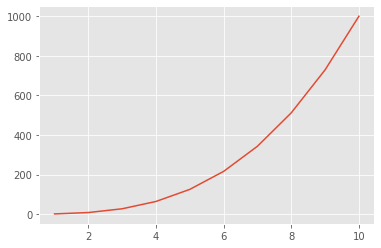

In [51]:
def power(x):
    return x**3

def power2(x,a):
    return x**a

x = range(1,11)
y = list(map(power, x))


plt.plot(x,y)

## Question 13


In [52]:
boston = pd.read_csv('../data/boston.csv')
boston['target'] = np.where(boston.crim > boston.crim.median(), 1, 0)
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv,target
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0,0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6,0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7,0
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4,0
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2,0


LR	Val acc:  0.8188976377952756
LDA	Val acc:  0.8110236220472441
QDA	Val acc:  0.8818897637795275
KNN (1)	Val acc:  0.9448818897637795
KNN (5)	Val acc:  0.9133858267716536


Text(0.5, 1.0, '')

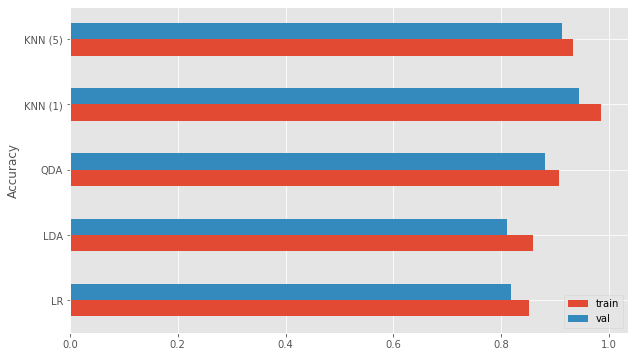

In [53]:
X = boston.drop(columns=['target','crim'])
y = boston.target

X_train, X_val, y_train, y_val = train_test_split(X, y)


models = [
    ('LR',LogisticRegression()), 
    ('LDA',LinearDiscriminantAnalysis()), 
    ('QDA',QuadraticDiscriminantAnalysis()),
    ('KNN (1)',KNeighborsClassifier(n_neighbors=1)),
    ('KNN (5)',KNeighborsClassifier(n_neighbors=5))
]


scores = {}
for name, model in models:
    
    print(name,end='\t')
    model.fit(X_train, y_train)
    val_preds = model.predict(X_val)
    print('Val acc: ',accuracy_score(y_val, val_preds))
    
    tr_preds = model.predict(X)
    val_preds = model.predict(X_val)
    
    tr_acc = accuracy_score(y, tr_preds)
    val_acc = accuracy_score(y_val, val_preds)
    
    scores[name] = {
        'train': tr_acc,
        'val': val_acc
    }

scores_df = pd.DataFrame.from_dict(scores, orient='index')
scores_df.plot.barh(figsize=(10,6))
plt.ylabel('Accuracy')
plt.title('')

KNN seems to outperform the others

Select best K

Text(0.5, 1.0, 'Accuracy over K Neighbours')

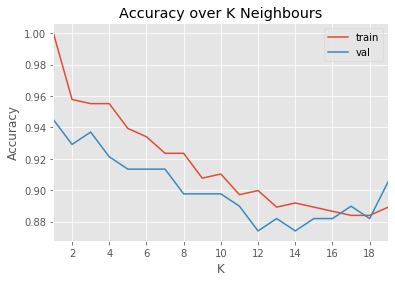

In [54]:
scores = {}
for k in range(1, 20):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    tr_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    
    tr_acc = accuracy_score(y_train, tr_preds)
    val_acc = accuracy_score(y_val, val_preds)
    
    scores[k] = {
        'train': tr_acc,
        'val': val_acc
    }

scores_df = pd.DataFrame.from_dict(scores, orient='index')
scores_df.plot()
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy over K Neighbours')

2 seems best

Now do feature selection

In [55]:
X.shape

(506, 13)

In [58]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

knn = KNeighborsClassifier(1)

sfs = SFS(knn, 
           k_features=(1,13), 
           forward=True, 
           floating=True, 
           verbose=0,
           scoring='accuracy',
           cv=10)

sfs.fit(X, y, custom_feature_names=X.columns)

SequentialFeatureSelector(clone_estimator=True, cv=10,
                          estimator=KNeighborsClassifier(algorithm='auto',
                                                         leaf_size=30,
                                                         metric='minkowski',
                                                         metric_params=None,
                                                         n_jobs=None,
                                                         n_neighbors=1, p=2,
                                                         weights='uniform'),
                          fixed_features=None, floating=True, forward=True,
                          k_features=(1, 13), n_jobs=1, pre_dispatch='2*n_jobs',
                          scoring='accuracy', verbose=0)

In [ ]:
# sfs.subsets_

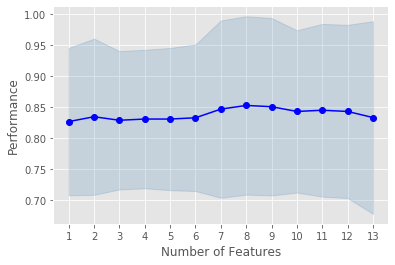

In [59]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

plot_sfs(sfs.get_metric_dict(), kind='std_dev');